# Part I: preprocessing

## Step 1: get the faces

In [143]:
import numpy as np
import cv2, os, sys
import scipy.misc as misc
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('ggplot')
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import sys
sys.path.insert(0, 'FaceDetect-master')
import multiprocessing
import pandas as pd

In [3]:
age = ['adult', 'child', 'elder', 'young']
sexual = ['male', 'female']

In [ ]:
def get_face_helper(file, face_cascade, min_neighbor=3):
    count = 0
    try_rescale = False
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=min_neighbor)
    if scale is None and len(faces) == 0:
        return gray
    elif scale and len(faces) == 0: # hass fail for origin image
        try_rescale = True
        faces, img, gray = get_scaling_faces(gray, scale)
        if len(faces) == 0: # haas fail for rescaled image
            return gray              
        continue
        
    has_face = False
    processed_img = None
    for (row, col, height, width), i in zip(faces, range(len(faces))):
        if height < min(img.shape[0], img.shape[1])*0.2:
            if i == len(faces)-1: # hass fail
                return gray                       
            else:                     
                continue
        elif processed_img is None:               
            processed_img = img[col:col+width, row:row+height]
        elif height > processed_img.shape[0]: # keep the largest square              
            processed_img = img[col:col+width, row:row+height]
    else:
        # success for retriving face
        return processed_img

In [148]:
def get_faces(data_path='data/', save_data_path='processed', age = ['adult', 'child', 'elder', 'young'], 
              sexual = ['male', 'female'], preserve_all=True, min_neighbor=3, second_detector=False,
              scale = None, write_origin=True, get_face_from_eyes=False, testing=False):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    counts = [0, 0, 0]
    if testing:
        for file in os.listdir(data_path):
            
    if second_detector:
        import FaceFinder
        import tensorflow as tf
        model_path = 'FaceDetect-master/face_model'
        def tf_detector_helper(file_path):
            tf.reset_default_graph()
            img = cv2.imread(path + file, 0)
            tf_faces, mask = FaceFinder.localize(img, model_path)
            return tf_faces, mask
    if scale:
        def get_scaling_faces(img, scale):
            i = cv2.resize(img, (int(img.shape[0]*scale), img.shape[1]))
            g = cv2.resize(gray, (int(gray.shape[0]*scale), gray.shape[1]))
            faces = face_cascade.detectMultiScale(g, scaleFactor=1.3, minNeighbors=min_neighbor)
            
            if len(faces) == 0:
                i = cv2.resize(img, (img.shape[0], int(img.shape[1]*scale)))
                g = cv2.resize(gray, (gray.shape[0], int(gray.shape[1]*scale)))
                faces = face_cascade.detectMultiScale(g, scaleFactor=1.3, minNeighbors=min_neighbor)
                
            return faces, i, g
    resolved_by_scale = pd.DataFrame(columns = ['age', 'sexual', 'file', 'success'])
    
    for a in age:
        for s in sexual:
            print(a, s, min_neighbor)
            path = data_path + a + '/' + s + '/'
            save_path = save_data_path + str(min_neighbor) + '/' + a + '/' + s + '/'
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            files = os.listdir(path)
            chunk = len(files) // 80
            for file, count in zip(files, range(len(files))):
                try_rescale = False
                if count % chunk == 0:
                    sys.stdout.write("\r[%s%s]" % ('=' * (count//chunk), ' ' * (80-count//chunk)))
                img = cv2.imread(path + file)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                if get_face_from_eyes:
                    img_ = img.copy()
                    gray_ = gray.copy()
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=min_neighbor)
                if write_origin:
                    cv2.imwrite((save_path + file).replace('.','_o.'), img)
                if scale is None and len(faces) == 0:
                    if second_detector: # use tensorflow
                        tf_faces, mask = tf_detector_helper(path+file)
                        if tf_faces is None: # tf fail
                            if preserve_all:
                                cv2.imwrite(save_path + file, img)
                        else:
                            cv2.imwrite(save_path + file, tf_faces)
                    elif not second_detector and perserve_all:
                        csv.imwrite(save_path + file, img)
                    continue
                elif scale and len(faces) == 0: # hass fail for origin image
                    try_rescale = True
                    faces, img, gray = get_scaling_faces(gray, scale)
                    if second_detector: # use tensorflow
                        tf_faces, mask = tf_detector_helper(path+file)
                        if tf_faces is None: # tf fail
                            if preserve_all:
#                                 cv2.imwrite(save_path + file, img)
                                print('')
                        else:
                            cv2.imwrite(save_path + file, tf_faces)
                    if len(faces) == 0: # haas fail for rescaled image
                        if get_face_from_eyes:
                            face = get_face_from_eyes_helper(img_)
                            if len(face) == 0:
                                cv2.imwrite(save_path + file.replace('.', '_o.'), img)
                                count[0] += 1
                            else:
                                cv2.imwrite(save_path + file.replace('.', '_e.'), face)                        
                        #resolved_by_scale = resolved_by_scale.append({'age':a, 'sexual':s, 'file':file, 'success':False}, ignore_index=True)
                        elif preserve_all and not write_origin:
                            cv2.imwrite(save_path + file.format('.','_o.'), img)
                            count[0] += 1
                        continue
                    
                
                has_face = False
                processed_img = None
                for (row, col, height, width), i in zip(faces, range(len(faces))):
                    if height < min(img.shape[0], img.shape[1])*0.2:
                        if i == len(faces)-1: # hass fail
                            if second_detector: # use tensorflow
                                tf_faces, mask = tf_detector_helper(path+file)
                                if preserve_all and not write_origin and tf_faces is None:
                                    cv2.imwrite(save_path + file, img)
                                else:
                                    cv2.imwrite(save_path + file, tf_faces)
                            elif get_face_from_eyes:
                                face = get_face_from_eyes_helper(img_)
                                if len(face) == 0:
                                    cv2.imwrite(save_path + file.replace('.', '_o.'), img)
                                else:
                                    cv2.imwrite(save_path + file.replace('.', '_e.'), face)
                            elif preserve_all and not write_origin:
                                if try_rescale:
                                    resolved_by_scale = resolved_by_scale.append({'age':a, 'sexual':s, 'file':file, 'success':False}, ignore_index=True)
                                cv2.imwrite(save_path + file.replace('.', '_e.'), img)                            
                            break
                        else:                     
                            continue
                    elif processed_img is None:               
                        processed_img = img[col:col+width, row:row+height]
                    elif height > processed_img.shape[0]: # keep the largest square              
                        processed_img = img[col:col+width, row:row+height]
                else:
                    # success for retriving face
                    if try_rescale:
                        resolved_by_scale = resolved_by_scale.append({'age':a, 'sexual':s, 'file':file, 'success':True}, ignore_index=True)
                    cv2.imwrite(save_path + file.replace('.', '_f.'), processed_img)
                    count[1] += 1
            print()
    if write_origin:
        return resolved_by_scale

IndentationError: expected an indented block (<ipython-input-148-36469ab13cd3>, line 10)

In [127]:
eyes

array([[463, 247,  44,  44],
       [904, 542,  50,  50]], dtype=int32)

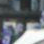

In [125]:
img = cv2.imread('data/adult/male/10.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=10)
has_eye = False
processed_imgs = []

left_eye = eyes[np.argmin(eyes, axis=0)[0]]
right_eye = eyes[np.argmax(eyes, axis=0)[0]]
eye_square_width = left_eye[2]
face = [max(left_eye[0]-eye_square_width*3, 0), max(left_eye[1]-eye_square_width*4, 0), eye_square_width*7, eye_square_width*6]
face = img[face[0]:min(face[0]+face[2], img.shape[1]), face[1]:min(face[1]+face[3], img.shape[0])]
#misc.toimage(face)
misc.toimage(img[eyes[0][0]:eyes[0][0]+eyes[0][2], eyes[0][1]:eyes[0][1]+eyes[0][3]])

In [131]:
def get_face_from_eyes_helper(img, min_neighbor=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=min_neighbor)
    has_eye = False
    processed_imgs = []

    if len(eyes) == 2:
        left_eye = eyes[np.argmin(eyes, axis=0)[0]]
        right_eye = eyes[np.argmax(eyes, axis=0)[0]]
        eye_square_width = left_eye[2] 
        if left_eye[0] + 2*eye_square_width < right_eye[0]:
            return []
        face = [max(left_eye[0]-eye_square_width*3, 0), max(left_eye[1]-eye_square_width*4, 0), eye_square_width*7, eye_square_width*6]
        face = img[face[0]:min(face[0]+face[2], img.shape[1]), face[1]:min(face[1]+face[3], img.shape[0])]
        return face
    else:
        return []

In [132]:
get_faces(save_data_path='preserve_and_resolve', scale=1.2, write_origin=False)

adult male 3
[===================================================================================]
adult female 3
[================================================================================]
child male 3
[=================================================================================]
child female 3
[=====================================================================================]
elder male 3
[=======================================================================================]
elder female 3
[==========================================================================================]
young male 3
[==================================================================================]
young female 3
[===================================================================================]


In [160]:
result[result['success']==False]

TypeError: 'NoneType' object is not subscriptable

## Step 2: resize the faces

In [85]:
def change_sizes(data_path = 'processed3', target_size=None, data_save_path=None, 
                 plot=False, resize_method='median', mode=None):
    """ resize given images
    resize_method: 
        resize the image size according to the given method
        "median", "max", "min", "mean"
    mode:
        mode to convert the image
        'RGB'(default), 'L'(grey scale)
        
    
    """
    methods = {'median':np.median, 'mean':np.mean, 'max':np.max, 'min':np.min}
    if target_size is None:
        sizes = []
        for a in age:
            for s in sexual:
                print(a, s)
                path = data_path + '/{}/{}/'.format(a, s)
                files = os.listdir(path)
                for file in files:
                    img = misc.imread(path + file)
                    sizes.append(img.shape[0])
        target_size = methods[resize_method](sizes)
        if plot:
            n, bins, patches = plt.hist(sizes, bins=100, normed=1, facecolor='green', alpha=0.75)
    #         mu, sigma = np.mean(sizes), np.std(sizes)
    #         y = mlab.normpdf(bins, mu, sigma)
    #         l = plt.plot(bins, y, 'r--', linewidth=1)
            plt.xlabel('size')
            plt.ylabel('count')
            plt.show()
            plt.close()
        
    
    if data_save_path is None:
        data_save_path = data_path + "/_resized/"
    for a in age:
        for s in sexual:
            print(a, s)
            path = data_path + '/{}/{}/'.format(a, s)
            files = os.listdir(path)
            img_save_path = data_save_path + '/{}/{}/'.format(a, s)
            if not os.path.exists(img_save_path):
                os.makedirs(img_save_path)
            for file in files:
                if mode == 'L':
                    resized_img = misc.imresize(misc.imread(path + file, mode='L'), size=(target_size, target_size, 3)) # bilinear
                else:
                    resized_img = misc.imresize(misc.imread(path + file), size=(target_size, target_size, 3)) # bilinear
                misc.imsave(img_save_path+file, misc.toimage(resized_img/255), )
            print()

In [87]:
change_sizes(data_path='processed_resolve3/', data_save_path='processed_resolve3_resized', target_size=128)

adult male

adult female

child male

child female

elder male

elder female

young male

young female



# Part II training

In [88]:
import lightgbm as gbm
import pandas as pd

In [134]:
def read_faces_as_dataframe(data_path='processed_reserve3_resized/', size=None):
    imgs = []
    target = []
    for a, i in zip(age, range(len(age))):
        for s, j in zip(sexual, range(len(sexual))):
            c = i*len(sexual) + j # class from 0 to 7
            count = 0
            print(a, s)
            path = data_path+'{}/{}/'.format(a, s)
            files = os.listdir(path)
            for file in files:
    #             if count > 100:
    #                 break
                count += 1
                if size is None:
                    imgs.append(misc.imread(path+file, mode='L').flatten())
                else:
                    imgs.append(misc.imresize(misc.imread(path+file, mode='L'), size=(size, size)).flatten())
                target.append(c)
    imgs = np.array(imgs)
    target = np.array(target).reshape(len(target), 1)
    imgs = np.hstack((imgs, target))
    return pd.DataFrame(imgs)

In [137]:
size=128
df = read_faces_as_dataframe(data_path='processed_resolve3_resized/', size=size)
test = df.sample(frac=0.1)
train = df.drop(test.index)
training = train.values.astype(np.uint8)
testing = test.values.astype(np.uint8)
np.save('training_grey_rescale_{}'.format(size), training)
np.save('testing_grey_rescale_{}'.format(size), testing)

adult male
adult female
child male
child female
elder male
elder female
young male
young female


In [12]:
#df.to_csv('training_data.csv', header=True, index=False) # slow and too big, don't use this

In [14]:
size=128
df = read_faces_as_dataframe(data_path='data/', size=size)
np.save('training_rescale{}'.format(size), df.values.astype(np.uint8))

adult male


KeyboardInterrupt: 

In [78]:
df = pd.DataFrame(np.load('training_grey_128.npy'))
test = df.sample(frac=0.1)
train = df.drop(test.index)
train_X = train[train.columns[:-1]].values.astype('float32')/255
train_t = train[train.columns[-1]].values
test_X = test[test.columns[:-1]].values.astype('float32')/255
test_t = test[test.columns[-1]].values
pca = PCA(50)
pca.fit(X=train_X)
train_X = pca.fit_transform(train_X)
test_X = pca.fit_transform(test_X)

In [85]:
clf = gbm.sklearn.LGBMClassifier(n_estimators=100, num_leaves=100, min_child_samples=20,
                                 learning_rate=0.1)

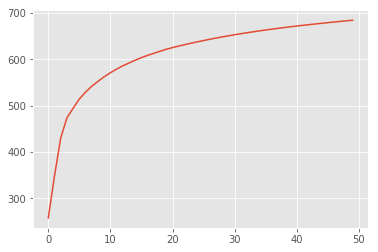

In [86]:
import matplotlib.pyplot as plt
plt.plot(range(len(pca.explained_variance_)), np.cumsum(pca.explained_variance_))
plt.show()

## 1. Auto-encoder

In [20]:
df.shape

(7384, 4097)

In [43]:
# mothod1, autoencoder
import keras
encoder = keras.models.load_model('encoder_grey_96')
autoencoder = keras.models.load_model('autoencoder_grey_96')

img_size=64
df = pd.DataFrame(np.load('training_grey_96.npy'))
test = df.sample(frac=0.1)
train = df.drop(test.index)
train_X = train[train.columns[:-1]].values.astype('float32')/255
train_t = train[train.columns[-1]].values
test_X = test[test.columns[:-1]].values.astype('float32')/255
test_t = test[test.columns[-1]].values
train_X = encoder.predict(train_X)
test_X = encoder.predict(test_X)

/usr/local/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [48]:
clf = gbm.sklearn.LGBMClassifier(n_estimators=500, num_leaves=20, min_child_samples=50)
clf.fit(train_X, train_t, eval_set=(test_X, test_t))

[1]	valid_0's multi_logloss: 2.05347
[2]	valid_0's multi_logloss: 2.03328
[3]	valid_0's multi_logloss: 2.01595
[4]	valid_0's multi_logloss: 2.0019
[5]	valid_0's multi_logloss: 1.98875
[6]	valid_0's multi_logloss: 1.97665
[7]	valid_0's multi_logloss: 1.96645
[8]	valid_0's multi_logloss: 1.9587
[9]	valid_0's multi_logloss: 1.94902
[10]	valid_0's multi_logloss: 1.94016
[11]	valid_0's multi_logloss: 1.93272
[12]	valid_0's multi_logloss: 1.9265
[13]	valid_0's multi_logloss: 1.92106
[14]	valid_0's multi_logloss: 1.91577
[15]	valid_0's multi_logloss: 1.91236
[16]	valid_0's multi_logloss: 1.90883
[17]	valid_0's multi_logloss: 1.90438
[18]	valid_0's multi_logloss: 1.90229
[19]	valid_0's multi_logloss: 1.89995
[20]	valid_0's multi_logloss: 1.8974
[21]	valid_0's multi_logloss: 1.89528
[22]	valid_0's multi_logloss: 1.89337
[23]	valid_0's multi_logloss: 1.88999
[24]	valid_0's multi_logloss: 1.88813
[25]	valid_0's multi_logloss: 1.88635
[26]	valid_0's multi_logloss: 1.88445
[27]	valid_0's multi_logl

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=20, min_child_weight=5,
        min_split_gain=0, n_estimators=500, nthread=-1, num_leaves=20,
        objective='multiclass', reg_alpha=0, reg_lambda=0,
        scale_pos_weight=1, seed=0, sigmoid=1.0, silent=True,
        skip_drop=0.5, subsample=1, subsample_for_bin=50000,
        subsample_freq=1, uniform_drop=False, xgboost_dart_mode=False)

In [49]:
train_result = clf.predict(train_X)
test_result = clf.predict(test_X)

In [50]:
train_acc = len(train_t[train_result == train_t]) / len(train_t)
test_acc = len(test_t[test_result == test_t]) / len(test_t)

In [51]:
print(train_acc, test_acc)

0.9474220501324638 0.25321100917431194


In [52]:
result_df = pd.DataFrame(columns=['type_of_AE', 'input_size', 'reserved_all', 'trees', 'acc'])

## 2. convolution auto-encoder

In [103]:
train_X.shape

(6646, 16384)

In [145]:
import keras

encoder = keras.models.load_model('conv_encoder_resolve_128')
autoencoder = keras.models.load_model('conv_autoencoder_resolve_128')

img_size = 128
train = pd.DataFrame(np.load('training_grey_rescale_128.npy'))
train_X = train[train.columns[:-1]].values.astype('float32')/255
train_t = train[train.columns[-1]].values
test = pd.DataFrame(np.load('testing_grey_rescale_128.npy'))
test_X = test[test.columns[:-1]].values.astype('float32')/255
test_t = test[test.columns[-1]].values

# encode and decode some digits
#encoder = Model(input_img, encoded)
train_X = encoder.predict(train_X)
test_X = encoder.predict(test_X)

/usr/local/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


ValueError: Error when checking : expected input_1 to have 4 dimensions, but got array with shape (6646, 16384)

In [140]:
import keras
encoder = keras.models.load_model('conv_encoder_resolve_128')
autoencoder = keras.models.load_model('conv_autoencoder_resolve_128')

img_size = 128
train = pd.DataFrame(np.load('training_grey_rescale_128.npy'))
train_X = train[train.columns[:-1]].values.astype('float32')/255
train_t = train[train.columns[-1]].values
test = pd.DataFrame(np.load('testing_grey_rescale_128.npy'))
test_X = test[test.columns[:-1]].values.astype('float32')/255
test_t = test[test.columns[-1]].values

# encode and decode some digits
#encoder = Model(input_img, encoded)
train_X = encoder.predict(train_X.reshape((len(train_X), img_size, img_size, 1)))
test_X = encoder.predict(test_X.reshape((len(test_X), img_size, img_size, 1)))
dim = train_X.shape[1] * train_X.shape[2] * train_X.shape[3]
train_X = train_X.reshape((len(train_X), dim))
test_X = test_X.reshape((len(test_X), dim))

/usr/local/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [150]:
import lightgbm as gbm
import pandas as pd
clf = gbm.sklearn.LGBMClassifier(n_estimators=200, num_leaves=10, min_child_samples=80)
clf.fit(train_X, train_t, eval_set=(test_X, test_t))

[1]	valid_0's multi_logloss: 2.05459
[2]	valid_0's multi_logloss: 2.03364
[3]	valid_0's multi_logloss: 2.01459
[4]	valid_0's multi_logloss: 1.995
[5]	valid_0's multi_logloss: 1.97808
[6]	valid_0's multi_logloss: 1.96281
[7]	valid_0's multi_logloss: 1.94707
[8]	valid_0's multi_logloss: 1.93315
[9]	valid_0's multi_logloss: 1.92021
[10]	valid_0's multi_logloss: 1.91061
[11]	valid_0's multi_logloss: 1.89765
[12]	valid_0's multi_logloss: 1.88874
[13]	valid_0's multi_logloss: 1.88051
[14]	valid_0's multi_logloss: 1.87115
[15]	valid_0's multi_logloss: 1.86318
[16]	valid_0's multi_logloss: 1.85663
[17]	valid_0's multi_logloss: 1.85013
[18]	valid_0's multi_logloss: 1.84422
[19]	valid_0's multi_logloss: 1.83827
[20]	valid_0's multi_logloss: 1.83299
[21]	valid_0's multi_logloss: 1.82743
[22]	valid_0's multi_logloss: 1.82309
[23]	valid_0's multi_logloss: 1.81996
[24]	valid_0's multi_logloss: 1.81646
[25]	valid_0's multi_logloss: 1.81455
[26]	valid_0's multi_logloss: 1.80937
[27]	valid_0's multi_lo

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=80, min_child_weight=5,
        min_split_gain=0, n_estimators=200, nthread=-1, num_leaves=10,
        objective='multiclass', reg_alpha=0, reg_lambda=0,
        scale_pos_weight=1, seed=0, sigmoid=1.0, silent=True,
        skip_drop=0.5, subsample=1, subsample_for_bin=50000,
        subsample_freq=1, uniform_drop=False, xgboost_dart_mode=False)

In [ ]:
misc.imshow(misc.toimage())

In [153]:
train_result = clf.predict(train_X)
test_result = clf.predict(test_X)
train_acc = len(train_t[train_result == train_t]) / len(train_t)
test_acc = len(test_t[test_result == test_t]) / len(test_t)
print(train_acc, test_acc)

0.9858561540776407 0.44173441734417346


In [211]:
import keras
encoder = keras.models.load_model('conv_encoder_resolve_128')
autoencoder = keras.models.load_model('conv_autoencoder_resolve_128')

img_size = 128
train = pd.DataFrame(np.load('training_grey_rescale_128.npy'))
train_X = train[train.columns[:-1]].values.astype('float32')/255
train_t = train[train.columns[-1]].values
test = pd.DataFrame(np.load('testing_grey_rescale_128.npy'))
test_X = test[test.columns[:-1]].values.astype('float32')/255
test_t = test[test.columns[-1]].values



/usr/local/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### result_df = pd.DataFrame(columns=['type_of_AE', 'input_size', 'reserved_all', 'augmentation', 'trees', 'train_acc', 'val_acc'])
result_df.append(pd.Series({'type_of_AE':'conv', 'input_size':96, 'reserved_all':True, 'augmentation':False, 'trees': 200, 'train_acc':97.5, 'val_acc':37.8}), ignore_index=True)
result_df.append(pd.Series({'type_of_AE':'conv', 'input_size':64, 'reserved_all':False, 'augmentation':False, 'trees': 200, 'train_acc':96.9, 'val_acc':36.9}), ignore_index=True)


In [207]:
import scipy.misc as misc
import numpy as np
path = '2/all/'
imgs = []
for i in range(640):
    #print(i)
    imgs.append(misc.imresize(misc.imread(path + str(i) + '.jpg', mode='L'), (128,128)).flatten())
df = pd.DataFrame(imgs)
training = df.values.astype(np.uint8)
np.save('testing_128', training)

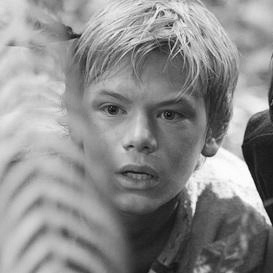

In [208]:
misc.toimage(misc.imread('2/all/0.jpg', mode='L'))

In [209]:
img_size=128
train_X = encoder.predict(df.values.reshape((len(df), img_size, img_size, 1)))
dim = train_X.shape[1] * train_X.shape[2] * train_X.shape[3]
train_X = train_X.reshape((len(train_X), dim))

In [214]:
df

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,216,215,214,215,215,216,217,217,216,213,...,35,37,39,41,36,38,45,48,48,50
1,229,229,229,229,229,229,238,241,239,239,...,179,119,102,100,97,98,100,101,97,95
2,49,48,49,53,55,65,76,58,55,56,...,135,118,63,47,103,132,101,77,69,68
3,225,216,209,166,161,189,223,221,190,129,...,77,80,100,101,46,30,31,31,33,37
4,255,255,255,255,255,255,255,255,255,255,...,76,78,71,68,65,57,51,54,59,68
5,84,69,93,174,218,194,127,126,159,173,...,226,226,226,226,226,226,227,229,231,231
6,23,24,36,107,132,134,135,137,140,141,...,220,208,198,149,47,32,28,25,23,23
7,254,255,255,252,244,207,136,109,111,103,...,141,135,139,143,139,129,128,131,120,116
8,14,11,13,13,13,13,13,15,15,15,...,11,9,10,9,9,11,11,10,13,20
9,63,64,65,67,68,68,68,70,70,69,...,106,103,99,97,94,79,51,42,44,46


In [217]:
train_result = clf.predict(df/255)
pd.DataFrame(train_result).to_csv('result.csv')

/usr/local/lib/python3.6/site-packages/lightgbm-0.2-py3.6.egg/lightgbm/sklearn.py:614: UserWarning: Using Pandas (default) integer column names, not column indexes. You can use indexes with DataFrame.values.
  class_probs = self.predict_proba(X, raw_score, num_iteration)
